# Image registration: mimumum working example
This notebook provides a sample implementation of the image registration approach described in detail in the paper "Image registration of low signal-to-noise cryo-STEM data" (doi: XXXXXX).  The code herein demonstrates the mimumum working example.  For more in-depth implementations (in particular, enabling more careful user-defined Fourier masking and outlier detection), see the additional two sample notebooks bundled with this package.  For a brief introduction to the approach implemented here, see the README.md file.  For more details, see the original paper.

If this code was a useful resource for your work, please consider citing the associated publication.

In [19]:
# Import global libraries and functions
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import splitext, basename
from time import time
from tifffile import imread, imsave
from IPython.display import Image
%matplotlib

# Import local libraries
import rigidregistration

Using matplotlib backend: Qt4Agg


In [20]:
# Load data.

# Here we use image stacks saved in .tif format, with 16-bit depth pixels.
# To load data saved in any of the image formats outputted by standard electron microscopy acquisition software (.dm3, .ser, etc.)
# into numpy arrays, we recommend the HyperSpy package (hyperspy.org).

f="/Users/Ben/Work/Data/20170711_Nb3Cl8/tiffs/11_unsavedStack_ZoneAxix3.tif"
stack=imread(f)
stack=np.rollaxis(stack,0,3)       # Restructed 3D array such that final axis iterates over images
stack=stack[:,:,:]/float(2**16)    # For best performance, data should be normalized between 0 and 1; alter this line for different bit-depth images
print("Analyzing {}.".format(f))

Analyzing /Users/Ben/Work/Data/20170711_Nb3Cl8/tiffs/11_unsavedStack_ZoneAxix3.tif.


In [21]:
# Inspect data to ensure it has been correctly loaded.

for i in range(0,5):
    fig,(ax1,ax2)=plt.subplots(1,2)
    ax1.matshow(stack[:,:,i],cmap='gray')
    ax2.matshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(stack[:,:,i])))),cmap='gray',vmin=np.average(np.log(np.abs(np.fft.fft2(stack[:,:,i]))))) 
    plt.show()

In [22]:
# Instantiate imstack object and acquire FFTs.

s=rigidregistration.stackregistration.imstack(stack)  # Replace 'stack' with stack[:,:,i:f] to only use images i to f
s.getFFTs()

## Fourier masking

#### Selecting a Fourier mask

The Fourier mask controls which information is used to align the image pairs.  The smaller the Fourier mask, the more the low-frequency information, i.e. slow variations in the image, is weighted to determine the correct alignments.  A smaller mask may be useful in cutting out noise, or in avoiding errors such as unit-cell misalignments in crystalline samples.  A mask that is too small may discard important structural information and lead to an imprecise alignment.

Fourier masks can be created with the makeFourierMask() method, which accepts the parameters:

    mask:   A string, indicating the functional form i.e. shape of the mask.  
            Options are: "bandpass", "lowpass", "hann", "hamming", "blackman", "gaussian", "none".
    n:      A float, controlling the mask size.  Features smaller than ~n pixels will be smoothed out 
            and ignored during image correlation.

A smaller mask may improve the accuracy of the registration, at the expense of degrading the precision.  For data with higher SNR or strong structural features, choosing a mask with n at the information limit is frequently sufficient.  For low-SNR data, data with few distinctive features, or highly translationally symmetric data, choosing a mask with a cutoff frequency near the primary Bragg peaks may be preferable, as this heavily weights low frequency information to avoid unit-cell hops, but ideally contains just enough lattice information to 'lock-in' to the lattice.  

The code below can be used to test various mask shapes and sizes for your data.  Both the FFT and the correlation function should be considered in choosing the best Fourier mask for a given dataset.  For more information on Fourier mask selection, see the README.md file, or the associated paper.

In [ ]:
Image("img/picture.png")

In [16]:
# Mask shape

# Display the mask shape options, and their effects on the crosscorrelation function between a pair of images.

masktypes=["bandpass","lowpass","hann","hamming","blackman","gaussian","none"]   # Mask shapes
n=4                                                                              # Mask size

i,j = 5,9                                  # Selects an image pair - the correlation function of these two images will be displayed 
for masktype in masktypes:                 # Iterate through all mask types
    s.makeFourierMask(mask=masktype,n=n)   # Set the mask shape and size
    s.show_Fourier_mask(i=i,j=j)           # Display the FFT of image i, the FFT with the mask applied, and the 
                                           # cross correlation function between images i and j

In [17]:
# Mask size

# Display the effect of varying the mask size on the cross correlation function between image pairs

masktype="hann"                             # Set mask shape

i,j = 5,9                                   # Choose image pair
for n in np.arange(2,12,2):                 # Iterate over various mask sizes
    s.makeFourierMask(mask=masktype,n=n)    # Set the mask shape and size
    s.show_Fourier_mask(i=i,j=j)            # Display the FFT of image i, the FFT with the mask applied, and the 
                                            # cross correlation function between images i and j

#### Fourier masking: anisotropic masks
For lattices lacking high rotational symmetry, an anisotropic mask may be preferable to avoid overweighting one lattice direction.  The makeFourierMask_eg() method creates an elliptical gaussian mask, and accepts parameters:

    n1:      A float, the mask size along the first axis.
    n2:      A float, the mask size along the second axis.
    theta:   A float, the tilt of the primary axes, in degrees.


In [8]:
# Make an elliptical Gaussian mask

n1=4             # Set mask size along axis 1
n2=2             # Set mask size along axis 2
theta=20         # Set tilt of mask axes, in degrees

i,j = 5,9 
s.makeFourierMask_eg(n1=n1,n2=n2,theta=np.radians(theta))   # Set the mask shape, size, and tilt
s.show_Fourier_mask(i=i,j=j)                                # Display

In [20]:
# Varying tilt of an elliptical Gaussian mask

n1=4                               # Mask size along axis 1
n2=2                               # Mask size along axis 2
thetas=[90,75,60,45,30,15,0]       # Tilt angles

i,j = 5,9                          # Choose image pair
for theta in thetas:                                             # Iterate through tilt angles
    s.makeFourierMask_eg(n1=n1,n2=n2,theta=np.radians(theta))    # Set the mask
    s.show_Fourier_mask(i=i,j=j)                                 # Display

## Calculate all relative image shifts
Find the relative shifts between all pairs of images.  For each pair of images (i,j), this is accomplished by:
1. Applying the selected Fourier mask
2. Calculating the (masked, i.e. weighted) cross correlation between images i and j
3. Identifying the maximum in the cross correlation


#### Step 1 - Applying the mask
The code from above should be used to select a good Fourier mask before the more computational intensive step of 
calculating all cross correlations is performed.  That said, iterating by fine tuning the Fourier mask choice 
based on the output of this step - the shift matrix - may sometimes be helpful.


In [7]:
# Once a suitable mask has been determined, set the mask with the makeFourierMask() or makeFourierMask_eg() method
# The last of these two functions to be run will determine the mask used when calculating image shifts.

n1=12
n2=9.106
theta=1.42

i,j = 5,9 
s.makeFourierMask_eg(n1=n1,n2=n2,theta=theta)
s.show_Fourier_mask(i=i,j=j)

/Users/Ben/Work/Projects/Active/rigidRegistration/code/rigidRegistration/rigidregistration/display.py:148: RuntimeWarning: divide by zero encountered in log
  ax2.matshow(np.log(np.abs(np.fft.fftshift(imstack.fftstack[:,:,i]*np.where(imstack.mask_fourierspace,imstack.mask_fourierspace,0.0001)))), cmap='gray',


#### Step 2 - Calculate cross correlation function
The cross correlation function is one of several types of correlation functions which may be appropriate for determining rigid image shifts.  Other options include the mutual correlation function, and phase correlation function.  For simplicity, only the cross correlation function is currently supported here.  For more information on alternative correlation functions, see, e.g. XXXX.

#### Step 3 - Identify maximum
Identifying the maximum in the cross correlation between images i and j may be performed one of two ways:
1. Brightest pixel: the brightest pixel in the cross correlation function is used as the maximum.  This has the advantages of simplicity and speed, but limits the precision to shifts of integer numbers of pixels.  However, because the final shift applied to a given image is determined using its relative shifts with respect to all other images, the final shift values are subpixel, with error due to pixelated maximum identification averaging out for large image stacks.
2. Guassian fitting: a gaussian fit is calculated about the brightest pixel.  This is aimed at atomic lattice images, and may not be suitable for data in which the cross correlation maximum is not approximately gaussian.  This approach provides a subpixel shift value, but adds additional complication and computation time.  An additional advantage of guassian fitting is that it may assist in avoiding identifying an incorrect, local maximum as the correct shift, particularly in cases where atomic peaks span only a handful of pixels, leading to the possibility of sampling errors. This is accomplished by fitting gaussians to the regions about brightest several pixels, and using the fitting gaussian with the largest amplitude.  For more information, see the original paper.

The findImageShifts() method accepts the following parameters:

    findMaxima:   A string, which sets the method used to identify the cross correlation maximum. 
                  Must be either 'pixel' for brightest pixel identification, or 'gf' for guassian fitting.
    verbose:      (optional) A boolean variable, which determines if the progress of the function is printed.
                  Default is True.

If gaussing fitting is used, three additional parameters must be set, using the s.setGaussianFitParams() method:

    num_peaks:     An integer, which sets the number of brightest pixels about which to fit gaussians. 
                   Must be either 'pixel' for brightest pixel identification, or 'gf' for guassian fitting.
                   If there are no concerns about sampling error, this may be set to 1.
    sigma_guess:   A float, which sets an initial guess for the width of the gaussian function.  May be set by
                   observing the shapes of the local maximum peaks in the cross correlation function, or the atomic
                   widths in the original data.
    window_radius: An int, setting the size of the region in which a guassian is fit.  The data used for the fit 
                   is a box of size 2*window_radius+1, centered at the brightest pixel.  May be set by observing 
                   the shapee of the local maximum peaks in the cross correlation function, and should ensure
                   neighboring peaks are excluded.


In [8]:
# Find all image shifts by identifying the brightest cross correlation pixel

findMaxima = 'pixel'                                       # Set method for cross correlation maximum identification

t0=time()                                                  # Time the image shift calculation
s.findImageShifts(findMaxima=findMaxima, verbose=False)    # Find all relative image shifts
t=time()-t0
print("Performed {} correlations in {} minutes {} seconds".format(s.nz*(s.nz-1)/2,int(t/60),t%60))

Performed 780.0 correlations in 0 minutes 8.274599075317383 seconds


In [12]:
# Find all image shifts using guassian fitting to identify cross correlation maxima

findMaxima = 'gf'                                                   # Set method for cross correlation maximum identification
s.setGaussianFitParams(num_peaks=3,sigma_guess=3,window_radius=4)   # Set gaussian fitting parameters

t0=time()                                                           # Time the image shift calculation
s.findImageShifts(findMaxima=findMaxima, verbose=False)             # Find all relative image shifts
t=time()-t0
print("Performed {} correlations in {} minutes {} seconds".format(s.nz*(s.nz-1)/2,int(t/60),t%60))

Performed 780.0 correlations in 0 minutes 35.90017509460449 seconds



Show the shift matrix with show_Rij() method.
If applicable, set range of minimum and maximum images to include with set_nz(nz_min,nz_max) method.
Find outliers with get_outliers(method, *args) method.  method parameter can be "NN", or "transitivity".  "NN" identifies outliers using only nearest neighbor elements of shift matrix, and requires an additional threshold parameter.  "transitivity" identifies outliers by identifying matrix elements which are inconsistent with physical stage positions, which must obey additive transitivity, and requires an additional threshold parameter, and an optional num_paths parameter.

## Assess the shift matrices
For a stack of N images, the shift matrices $X_{ij}$ and $Y_{ij}$ are NxN matrices, in which $X_{ij}$ is the shift in the x-direction of image j with respect to image i (and similarly for $Y_{ij}$).  Note that these matrices are skew-symmetric, i.e. $X_{ji} = -X_{ij}$.

Importantly, in order to be physically consistent, the shift matrices must respect the transitivity of vector addition, i.e.

$\mathbf{R}_{ik} = \mathbf{R}_{ij} + \mathbf{R}_{jk}$

where $\mathbf{R}_{ij} = X_{ij}\mathbf{\hat{x}} + Y_{ij}\mathbf{\hat{y}}$.
It is therefore possible to ensure good image registration simply by enforcing that the sets of all relative image
shifts are consistent in that they obey transitivity.

#### Visually assess the shift matrices
Visually, transitivity implies that the shift matrices should 'look smooth', in a certain sense.
They need not necessarily vary monotonically, and abrupt changes are possible - i.e. the stage drift may change direction - however any abrupt change should then appear in many places in the shift matrix (along rows/columns), as it will affect many relative image shift pairs.  Individual abberant matrix elements are generally unphysical.


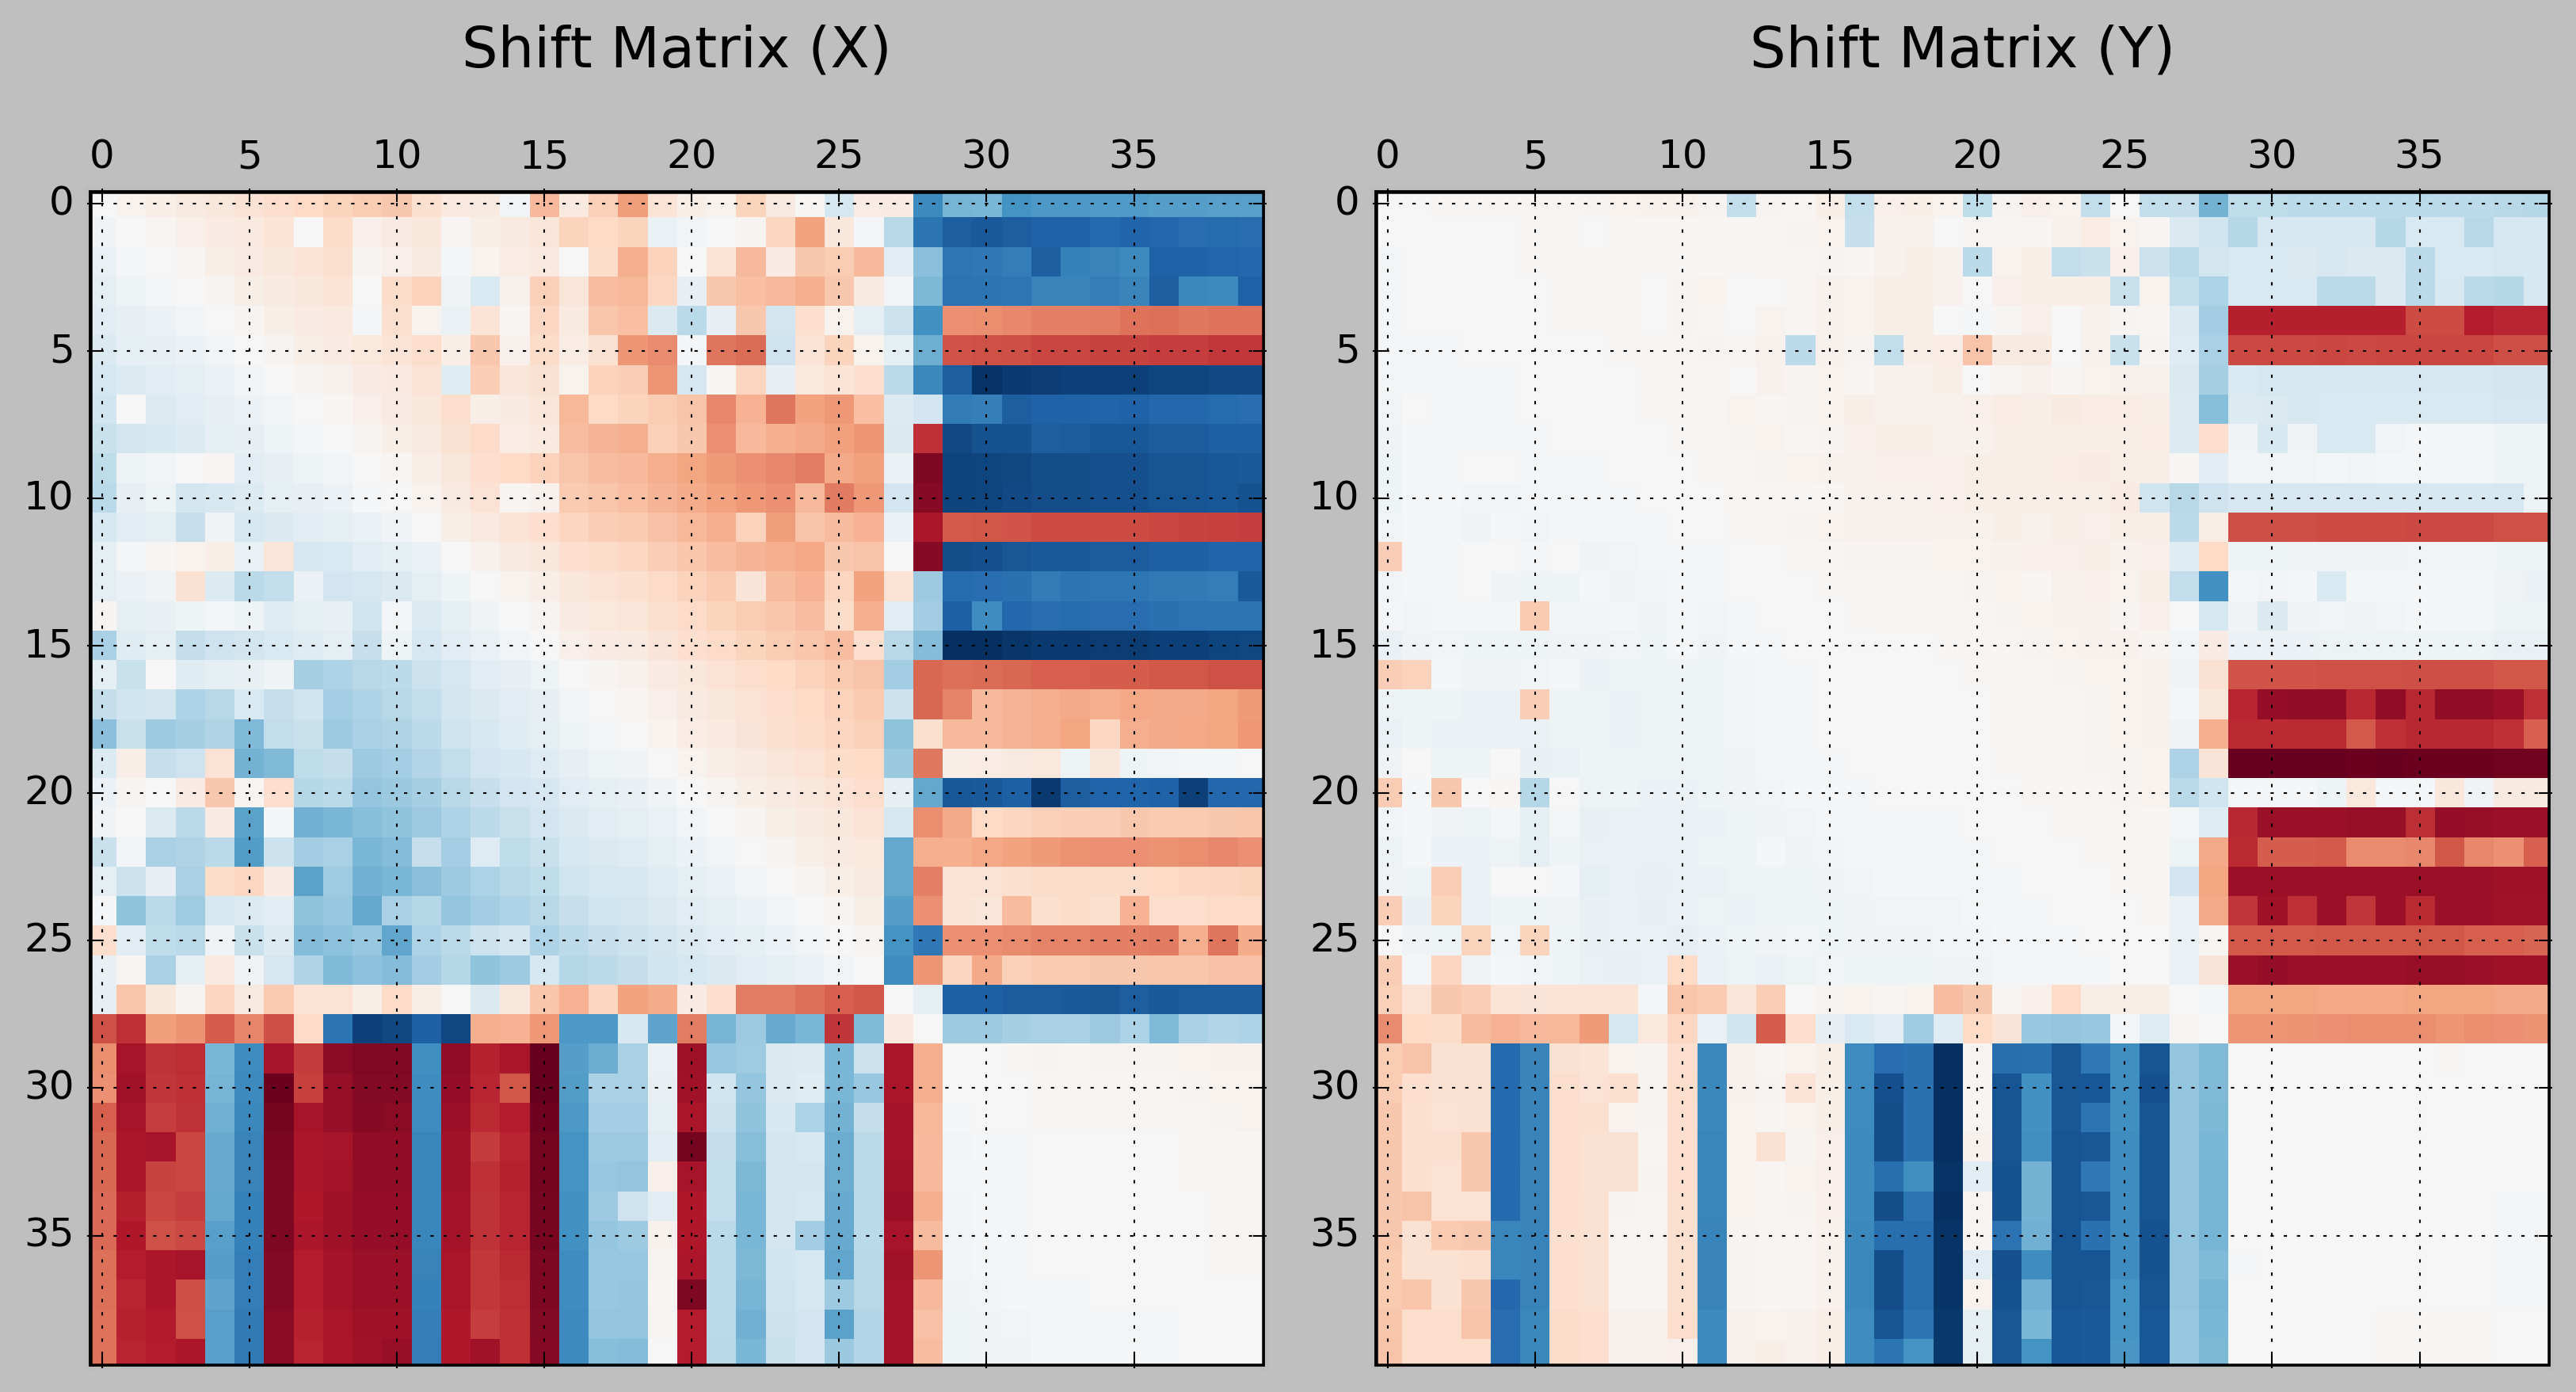

In [10]:
# Show Xij and Yij matrices
s.show_Rij()

#### Identify incorrect matrix elements
Identifying incorrect matrix elements can be performed in several ways:
1. Throw away entire images
2. Automatically identify outliers in the shift matrices
3. Identify outliers by hand

The code below demonstrates how each of these approaches can be implemented.

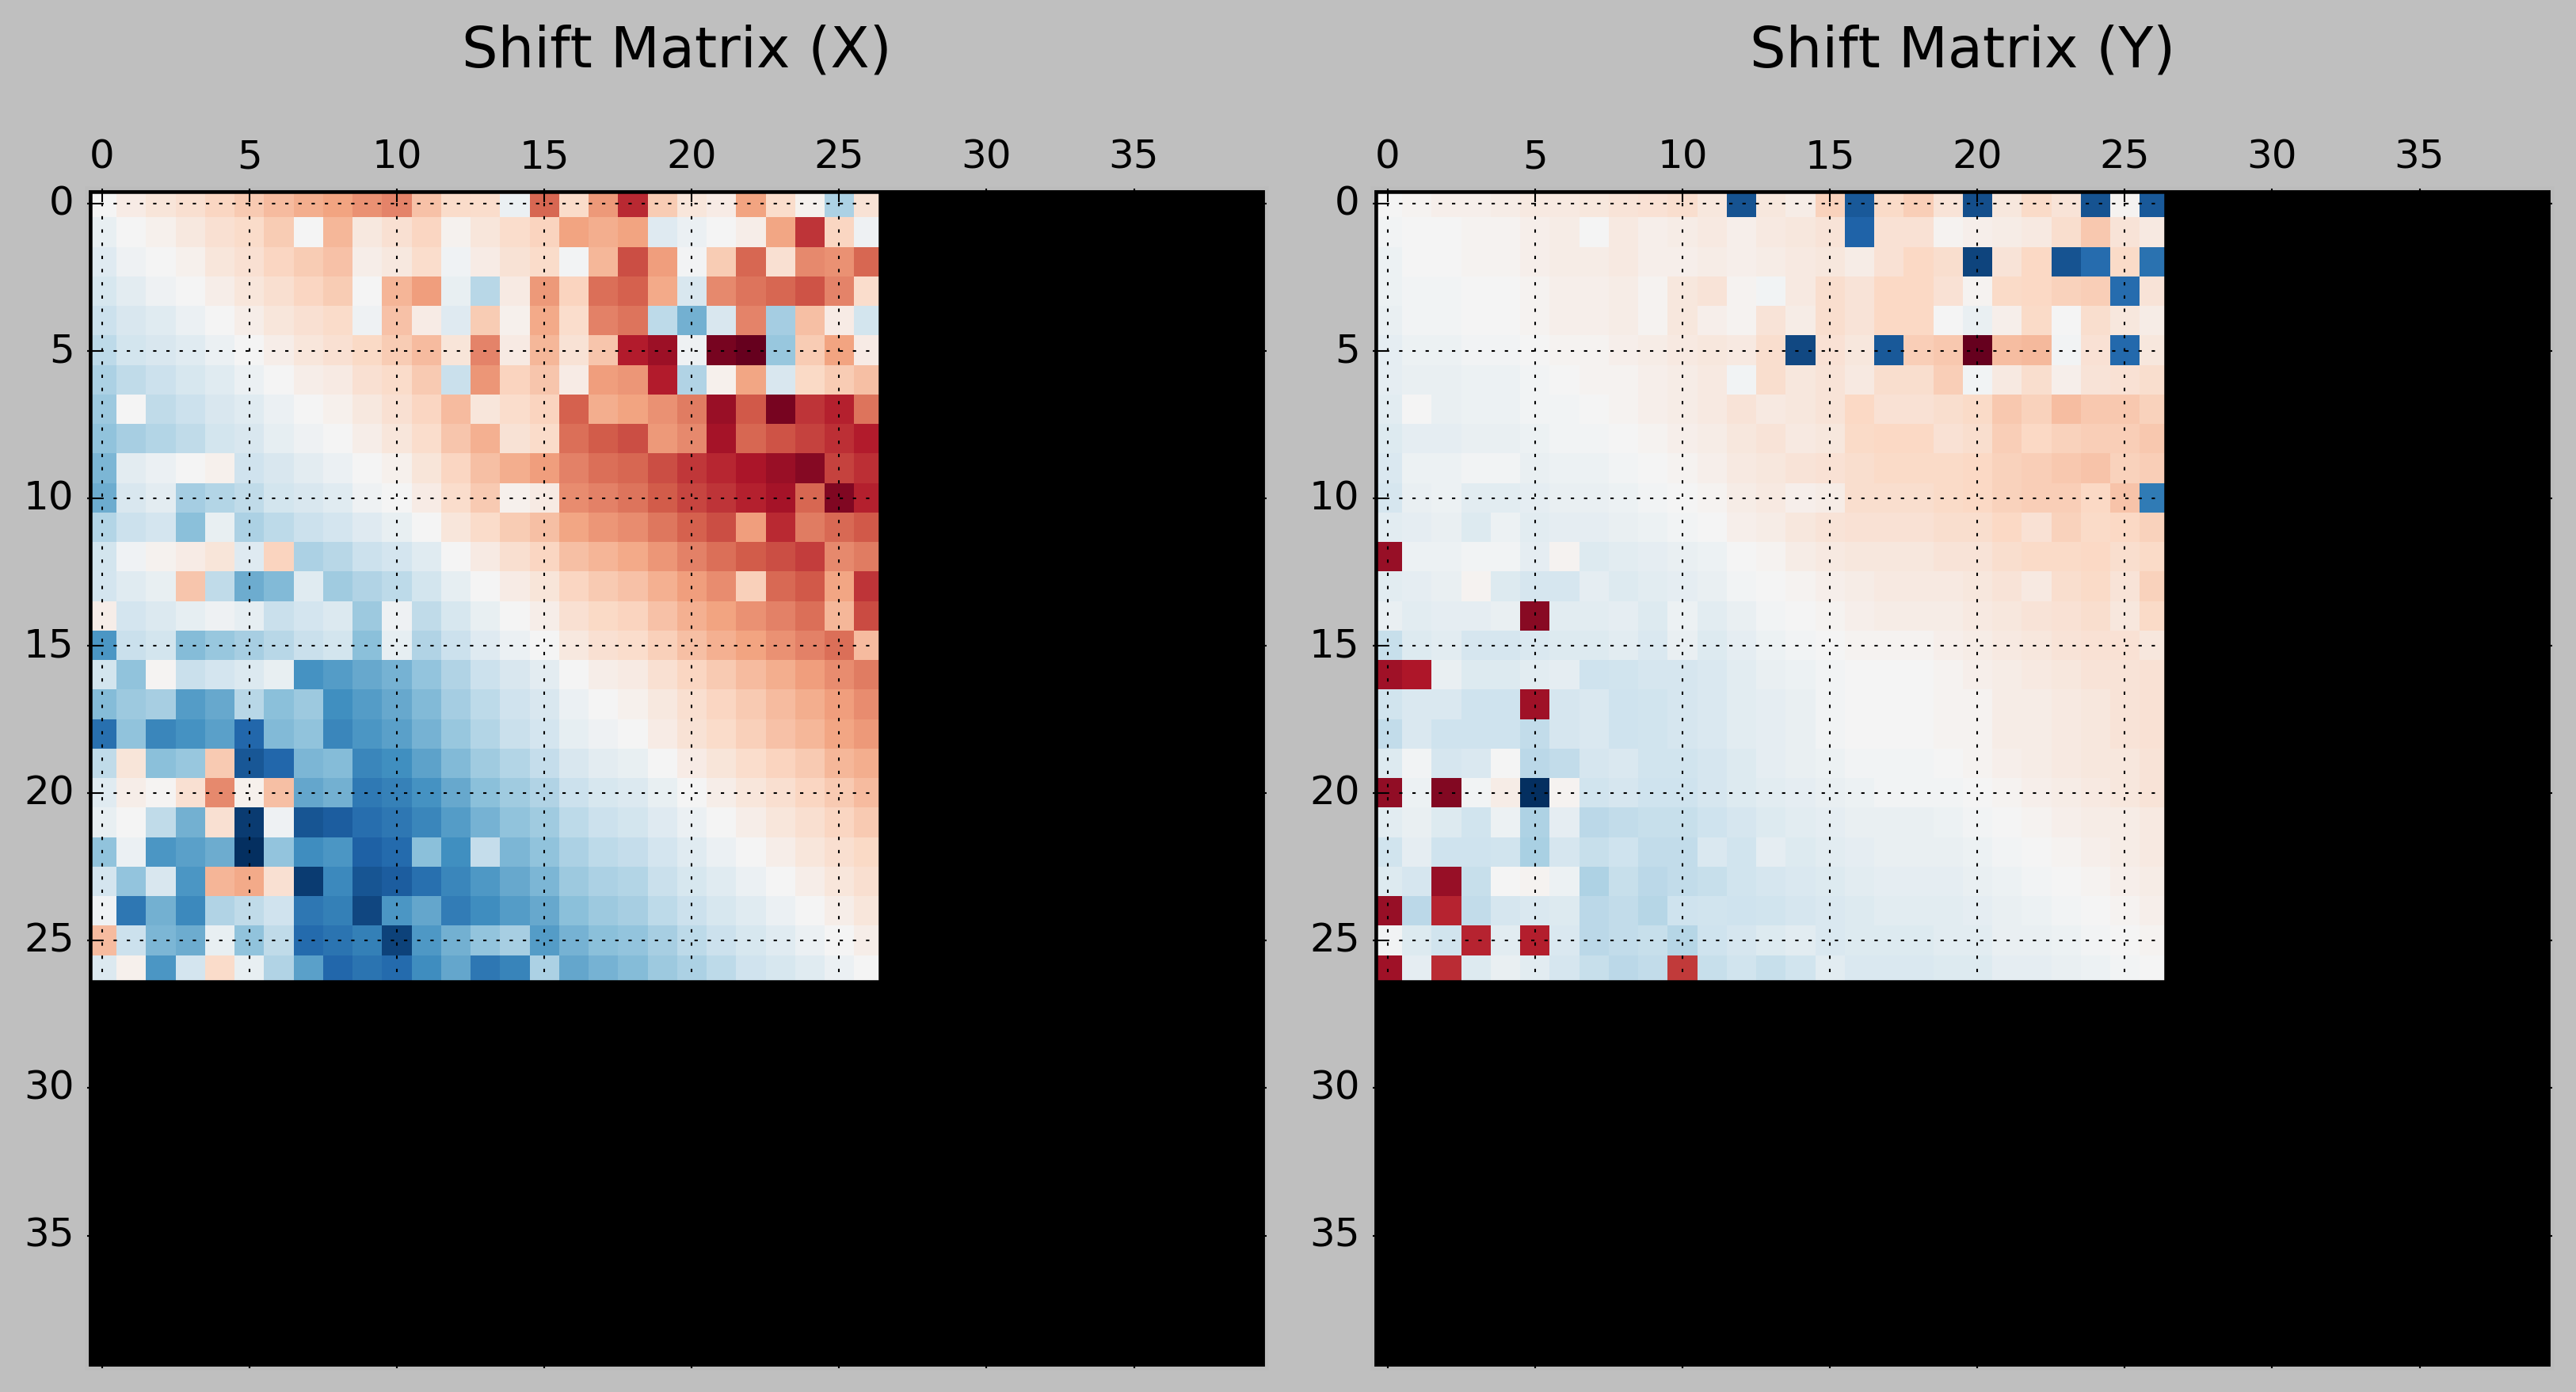

In [11]:
# Throw away entire images - option 1: use a consecutive subset of the image stack

s.set_nz(0,27)               # Set min/maz useable image indices.  Images outside this range will not be used.
s.show_Rij(mask=True)        # Display

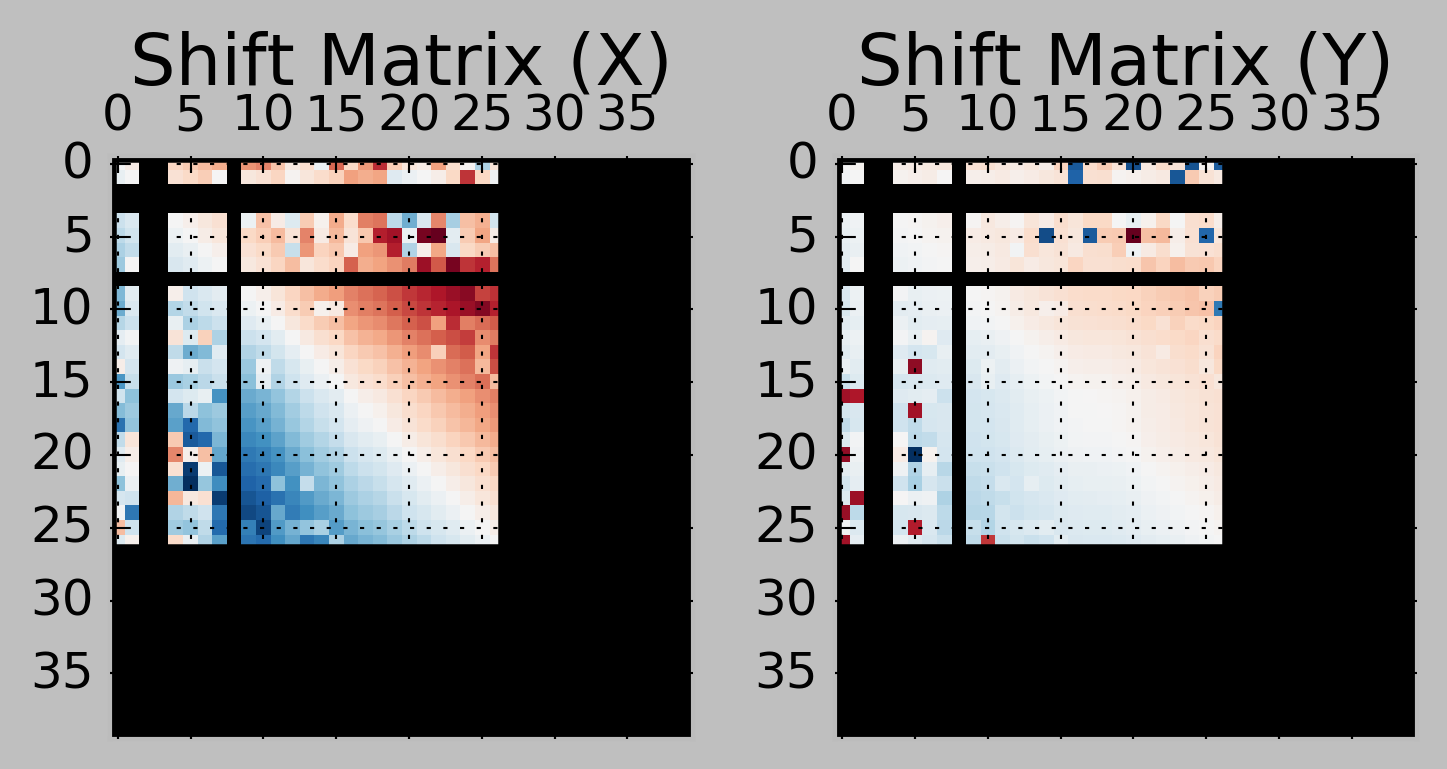

In [15]:
# Throw away entire images - option 2: select bad images

s.set_bad_images([2,3,8])    # Images with selected indices will not be used.
s.show_Rij(mask=True)        # Display

In [18]:
# Automatically identify outliers - option 1: enforce smoothness by comparing to nearest neighbors

s.get_outliers("NN",10)       # Set outlier threshhold

In [42]:

s.get_outliers("transitivity",5,5)       # Set outlier threshhold

In [14]:
s.show_Rij(mask=True)        # Display

In [15]:
s.get_outliers?

In [18]:
# Automatically identify outliers - option 1: enforce smoothness by comparing to nearest neighbors

s.set_nz(0,27)               # Set min/maz useable image indices

s.get_outliers("transitivity",10,10)       # Set outlier threshhold
s.set_bad_images([])         # Set bad images

s.show_Rij(mask=True)

In [19]:
# Optionally, add or remove points from the outlier mask that were not correctly identified

correct_pairs=[[11,12],[11,13]]
incorrect_pairs=[[1,9]]

for pair in correct_pairs:
    i,j=pair[0],pair[1]
    s.Rij_mask[i,j]=1
    s.Rij_mask[j,i]=1
for pair in incorrect_pairs:
    i,j=pair[0],pair[1]
    s.Rij_mask[i,j]=0
    s.Rij_mask[j,i]=0
    
s.show_Rij()

In [20]:
s.Rij_mask[:5,15]=0
s.Rij_mask[:3,18]=0
s.Rij_mask[:8,24:26]=0
s.Rij_mask[15,:5]=0
s.Rij_mask[18,:3]=0
s.Rij_mask[24:26,:8]=0

s.show_Rij()

### Remove outliers
The make_corrected_Rij() method determines the correct values for outliers in the shift matrices using transitivity, and the show_Rij_c() method shows the corrected shift matrices.

This step is optional, as it is performed automatically when get_average_image() is run if not called manually.
However, manually calling make_corrected_Rij() is recommended so that the final shift matrices can be visually inspected to ensure physical consistency.

In [21]:
s.make_corrected_Rij()
s.show_Rij_c()

### Calculate average image

In [22]:
# Create registered image stack and average

s.get_averaged_image()

In [23]:
# Display final image

s.show()

In [24]:
# Display report of registration procedure

s.show_report()

In [25]:
# Save report of registration procedure

s.save_report("/Users/Ben/Desktop/test_report.pdf")

Note that the full field of view of the original data has been preserved in the final image for computational simplicity, however, data at the edges is not physically meaningful.  All shifts are stored as 1D arrays in the attributes shifts_x and shifts_y, thus to obtain the limits of physical meaningful data, use, e.g. s.shifts_x.max(), s.shifts_x.min(), etc.